In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt 
import csv 
import re 

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from math import sqrt
from sklearn.model_selection import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot

sns.set(style='white', context='notebook', palette='deep')

In [2]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

In [3]:
pip install PyDrive

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
downloaded = drive.CreateFile({'id':"1EwH69uQtYm7W3MxZ8k308i4mfqKYq9ww"})   # replace the id with id of file you want to access
downloaded.GetContentFile('covid_test.csv')        # replace the file name with your file

In [8]:
#link çalışıyor mu kontrol ederiz 
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [9]:
dataset = pd.read_csv('covid_test.csv')
values = dataset.values
print(dataset)

      sira  random  model1  Model-2  ...  Model-8  Model-9  Model-10  Label
0      644       1       1        1  ...        1        0         1      0
1     1098       2       1        1  ...        1        1         1      1
2     1390       3       1        1  ...        1        1         1      1
3     2931       4       1        1  ...        1        1         1      1
4     1154       5       1        1  ...        1        1         1      1
...    ...     ...     ...      ...  ...      ...      ...       ...    ...
3251  3102    3252       1        1  ...        1        1         1      1
3252  2974    3253       1        1  ...        1        1         1      1
3253  3048    3254       1        1  ...        1        1         1      1
3254  3157    3255       1        1  ...        1        1         1      1
3255    32    3256       0        0  ...        0        0         0      0

[3256 rows x 13 columns]


In [10]:
# convert series to supervised learning
def series_to_supervised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
# standardizasyon 
scaler = MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

In [12]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [13]:
dataset = dataset.drop('sira', axis=1)

In [14]:
dataset = dataset.drop('random', axis=1)


In [15]:
dataset.head()

,model1,Model-2,Model-3,Model-4,M0del-5,Model-6,Model-7,Model-8,Model-9,Model-10,Label
0,1,1,1,1,0,1,1,1,0,1,0
1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1


In [16]:

# split into train and test sets

X = values[:,1:11]
y = values[:,11]

In [17]:
print(X)
print(y)

[[   1    1    1 ...    1    1    0]
 [   2    1    1 ...    1    1    1]
 [   3    1    1 ...    1    1    1]
 ...
 [3254    1    1 ...    1    1    1]
 [3255    1    1 ...    1    1    1]
 [3256    0    0 ...    0    0    0]]
[1 1 1 ... 1 1 0]


In [18]:
dataset.isnull().sum().sort_values(ascending = True)

model1      0
Model-2     0
Model-3     0
Model-4     0
M0del-5     0
Model-6     0
Model-7     0
Model-8     0
Model-9     0
Model-10    0
Label       0
dtype: int64

In [19]:
dataset.head()

,model1,Model-2,Model-3,Model-4,M0del-5,Model-6,Model-7,Model-8,Model-9,Model-10,Label
0,1,1,1,1,0,1,1,1,0,1,0
1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1


**Random Forest **

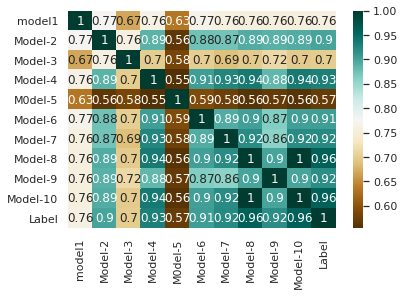

In [ ]:
g = sns.heatmap(dataset[["model1","Model-2","Model-3","Model-4","M0del-5","Model-6","Model-7","Model-8","Model-9", "Model-10","Label"]].corr(),cmap="BrBG",annot=True)

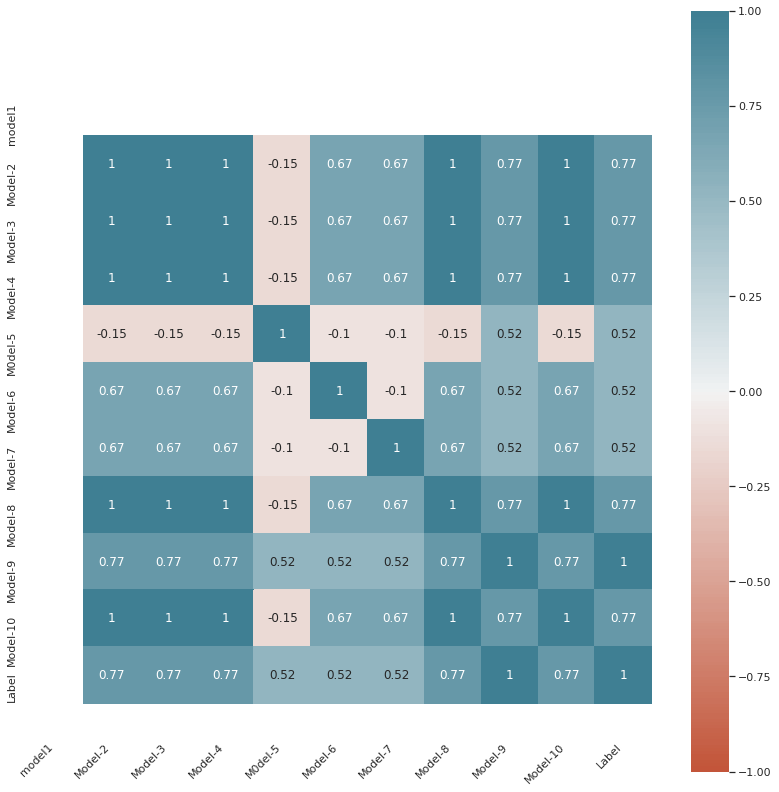

In [68]:
# Correlation of the features
import seaborn as sns
correlation = dataset[0:11].corr()

plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_ylim(len(correlation)+0.5, -0.5);

In [20]:
# split into train and test
n_train = 2000
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

In [21]:
# Cross validation için K fold ayarlama 
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGIST

[0.7675, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9164999999999999, 0.5464999999999999, 1.0, 0.985] [0.0025000000000000022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2272449119342389, 0.19902323984901862, 0.0, 0.006324555320336764] [0.98  0.98  0.99  0.99  0.99  0.995 0.975 0.98  0.98  0.99 ]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


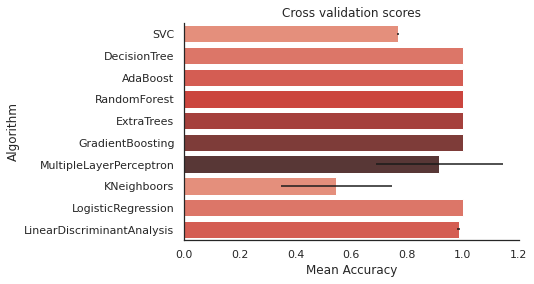

In [22]:
# Modeling
#not: datasette muhakkak string kalmasın hepsi dummy olsun yoksa hata veriyor 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.01))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
#burada her classifier için cross validation scorelar elde edilir 
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y= y_train, scoring = "accuracy", cv = kfold, verbose=0))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
#sonuçlar yazdırılır. 
print(cv_means ,cv_std, cv_result)
#sonu.lar list olarak kaydedilir. 
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost", "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
g = sns.barplot("CrossValMeans",y="Algorithm",data = cv_res, palette=sns.color_palette("Reds_d", n_colors=7, desat=1),orient = "h",**{'xerr':cv_std}, errwidth=None)
g.set_xlabel("Mean Accuracy",fontsize=12)
g = g.set_title("Cross validation scores")
sns.despine()
plt.show()

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 2,3,4,5],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print("best score","=", gsRFC.best_score_)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.7s


best score = 1.0


[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   56.6s finished


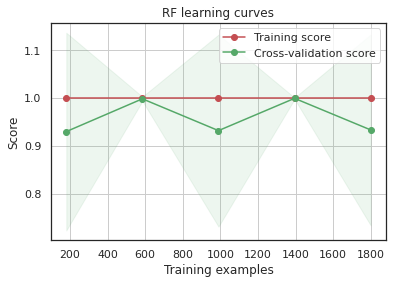

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Test and training data bazlı learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF learning curves",X_train,y_train,cv=kfold)


**DNN**

In [23]:
values = reframed.values
X = values[:,1:11]
y = values[:,11]

y = to_categorical(y)
print(y)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [24]:

# split into train and test sets
#values = reframed.values

# split into train and test
n_train = 2000
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]
# network architecture
model = Sequential()
model.add(Dense(6, input_dim=10,  activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, input_dim=10,  activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, input_dim=10,  activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Train: 1.000, Test: 0.998


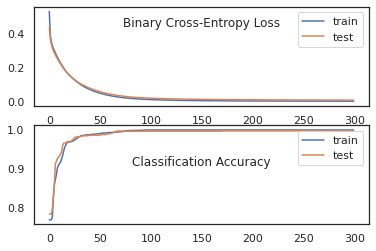

In [25]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Binary Cross-Entropy Loss', pad=-20)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Classification Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

print(yhat_classes)
print(yhat_probs)

[1 0 1 ... 1 1 1]
[[5.6573725e-08 1.0000000e+00]
 [9.9997079e-01 2.9193481e-05]
 [5.6794498e-08 1.0000000e+00]
 ...
 [1.0283590e-06 9.9999893e-01]
 [1.0307468e-06 9.9999893e-01]
 [1.0331452e-06 9.9999893e-01]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
y_test1 = values[2000:,11]
print(y_test1)

[1. 0. 1. ... 1. 1. 1.]


In [28]:
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score
accuracy = accuracy_score(y_test1, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test1, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test1, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test1, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.997610
Precision: 1.000000
Recall: 0.996945
F1 score: 0.998470


In [29]:
# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test1, yhat_classes)
print(matrix)

[[273   0]
 [  3 979]]


ENSEMBLE MODEL CONTRIBUTIONS 

In [43]:
dataset = pd.read_csv('covid_test.csv')
values = dataset.values
X = values[:,1:11]
y = values[:,11]


In [44]:
def evaluate_model(X_train, y_train, X_test, y_test):
# define model
   # split into train and test
   n_train = 2001
   X_train, X_test = X[:n_train, :], X[n_train:, :]
   y_train, y_test = y[:n_train], y[n_train:]
   trainy_enc = to_categorical(y_train)
   testy_enc = to_categorical(y_test)
   model = Sequential()
   model.add(Dense(6, input_dim=10, activation='relu'))
   model.add(Dense(6, input_dim=10, activation='relu'))
   model.add(Dense(6, input_dim=10, activation='relu'))
   model.add(Dense(2, activation='softmax'))
   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
   model.fit(X_train,  trainy_enc, epochs=300, verbose=0)
# evaluate the model
   _, test_acc = model.evaluate(X_test, testy_enc, verbose=0)
   return model,test_acc

In [45]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, X_test):
# make predictions
   yhats = [model.predict(X_test) for model in members]
   yhats = array(yhats)
# sum across ensemble members
   summed = numpy.sum(yhats, axis=0)
# argmax across classes
   result = argmax(summed, axis=1)
   return result
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, X_test, y_test):
# select a subset of members
   subset = members[:n_members]
# make prediction
   yhat = ensemble_predictions(subset, X_test)
# calculate accuracy
   return accuracy_score(y_test, yhat)


In [46]:
from sklearn.model_selection import train_test_split
# generate dataset
n_train = 2001
X_trainnew, X_new = X[:n_train, :], X[n_train:, :]
y_trainnew, y_new = y[:n_train], y[n_train:]

# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):

# evaluate model
   model, test_acc = evaluate_model(X_train, y_train, X_test, y_test)
   print('>%.3f' % test_acc)
   scores.append(test_acc)
   members.append(model)

>0.959
>0.999
>0.998
>1.000
>1.000
>0.998
>0.993
>0.782
>1.000
>0.997


In [47]:
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy
from sklearn.metrics import accuracy_score

#summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

Estimated Accuracy 0.973 (0.065)


> 1: single=0.959, ensemble=0.959
> 2: single=0.999, ensemble=0.996
> 3: single=0.998, ensemble=0.998
> 4: single=1.000, ensemble=0.999
> 5: single=1.000, ensemble=0.999
> 6: single=0.998, ensemble=0.999
> 7: single=0.993, ensemble=0.999
> 8: single=0.782, ensemble=0.999
> 9: single=1.000, ensemble=0.999
> 10: single=0.997, ensemble=0.999
Accuracy 0.973 (0.065)


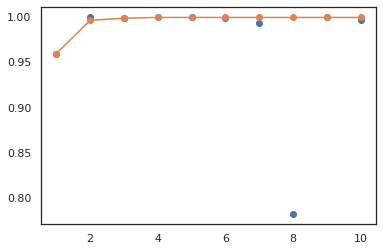

In [48]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
   ensemble_score = evaluate_n_members(members, i, X_new, y_new)
   y_new_enc = to_categorical(y_new)
   _, single_score = members[i-1].evaluate(X_new, y_new_enc, verbose=0)
   print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
   ensemble_scores.append(ensemble_score)
   single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()